### Model 1 

Forecast Price per meter^2 by district

**Question(s) to Answer:**

- How will the prices per square meter and per disctricy be next quarter? (Fixed at 2009)

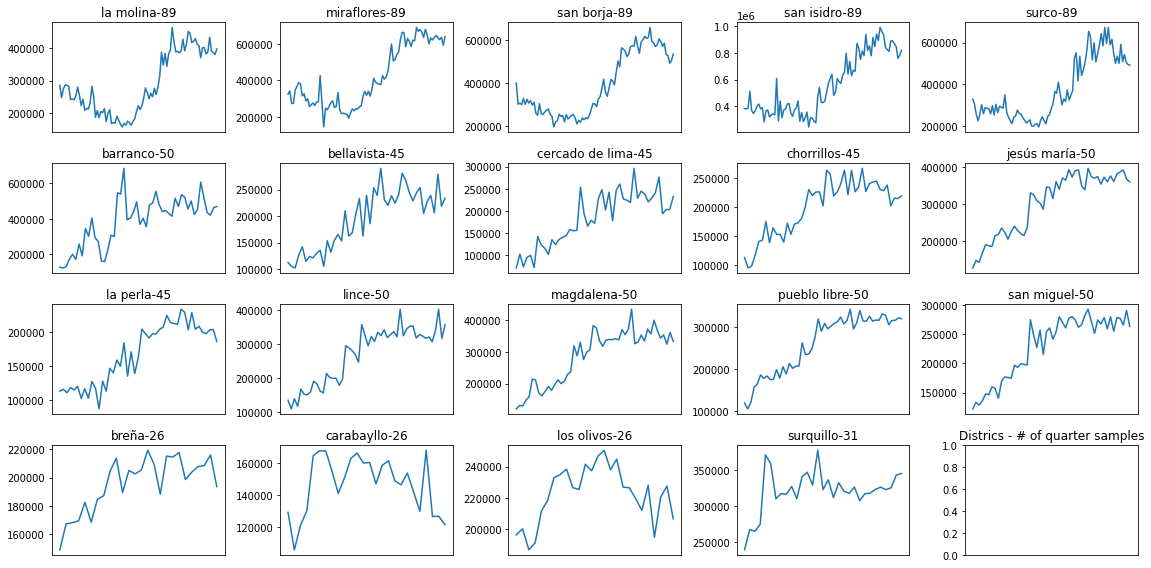

In [1]:
import pandas as pd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

from itertools import product
from sklearn.impute import KNNImputer

pd.set_option('display.max_columns',None)

#Apartments data
data = pd.read_excel('../input/BCRP-depas.xlsx')
data['Periodo'] = data['Año'].astype(str) + '_' + data['Trimestre'].astype(str)
data['Distrito'] = data['Distrito'].str.lower()
#Macroeconomic data
macro_data = pd.read_csv('../input/macro_data/macro-1999-2019-1.csv')
macro_data['Fecha'] = pd.to_datetime(macro_data['Fecha'])

#Basic EDA
#Time Series behavior. It seems all have the same movement.
ts_districts = data.groupby(['Periodo','Distrito'])['Precio en soles constantes de 2009'].median().reset_index()

fig, axes = plt.subplots(4,5, figsize=(16,8))

tuples_axes = tuple(product([0,1,2,3,4],repeat=2))

for tuple_, district in zip(tuples_axes[:-6],ts_districts['Distrito'].unique()):
    df = ts_districts[ts_districts['Distrito'] == district]
    sns.lineplot(ax = axes[tuple_[0],tuple_[1]], x = df['Periodo'].values, y=df['Precio en soles constantes de 2009'].values)
    axes[tuple_[0],tuple_[1]].set_title(district + '-'+ str(df['Periodo'].nunique()))

plt.setp(axes, xticks=[])

plt.title('Districs - # of quarter samples')
fig.tight_layout()
plt.show()


# To simplify the problem we will only work with the following districts:

prototyping_districts = ['surco', 'miraflores', 'la molina', 'san borja', 'san isidro', 
                         'san miguel', 'magdalena', 'jesús maría', 'pueblo libre', 'lince', 'barranco']

df = data[data['Distrito'].isin(prototyping_districts)]

#At this point, we will not think too much about the reason of the nan values. We chosen to
#replace NaN values with the mode per district and year.

spec_columns = ['Número de habitaciones', 'Número de baños',
       'Número de garajes', 'Piso de ubicación', 'Vista al exterior',
       'Años de antigüedad'] #specific columns for nan apartment columns

mode_groupby_data = df.groupby(['Distrito'])[spec_columns].agg(lambda x: x.mode()[0]) #which index is the district

for district in df['Distrito'].unique():
    for nan_col in spec_columns:
        index_nan_temp = df[(df['Distrito'] == district)&(df[nan_col].isna())].index
        warnings.filterwarnings('ignore')
        df.loc[index_nan_temp, nan_col] = mode_groupby_data[mode_groupby_data.index.str.contains(district)][nan_col].values[0]
        
#Transform Price and Surface to logs
df['Precio en soles constantes de 2009'] = np.log(df['Precio en soles constantes de 2009'])
df['Superficie '] = np.log(df['Superficie '])

df['Precio_m2'] = df['Precio en soles constantes de 2009']/df['Superficie ']

#Mapping numeric columns (años de antiguedad) into categories
df['antiguedad_cat'] = pd.cut(df['Años de antigüedad'], 5, labels=['nuevo','seminuevo','normal','viejo','muy viejo'])

#Mapping numeric location floor into categories
df['piso_cat'] = pd.cut(df['Piso de ubicación'], 3, labels=['bajo','medio','alto'])

#drop erratic data
df.drop(df[df['Número de habitaciones'] == 0].index,inplace=True)

**We will reshape the dataset for time series analysis**

In [2]:
df.drop(['Año','Trimestre','Precio en dólares corrientes','Precio en soles corrientes','Precio en soles constantes de 2009'],axis=1, inplace=True)

df['Periodo']=df['Periodo'].map({x :((pd.to_datetime(x[:4]) + pd.offsets.QuarterEnd(int(x[5:]))) + datetime.timedelta(days=1))\
                                 for x in df['Periodo'].unique()}).dt.floor('D')

df.rename(columns={'Periodo':'Fecha'},inplace=True)

In [3]:
#Merge with Macro data:
to_train = df.merge(macro_data, on='Fecha',how='left').dropna()

In [4]:
#In order to make apartment characteristics unique, we will use PCA as an proxy indicator for that

#Encode categorical variables: Distrito, antiguedad_cat, piso_cat
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in ['Distrito','antiguedad_cat','piso_cat']:
    le.fit(to_train[col].values)
    to_train[col] = le.transform(to_train[col].values)

In [5]:
X_to_reduce = to_train[['Número de habitaciones', 'Número de baños','Número de garajes', 'Vista al exterior','piso_cat']]

#PCA as an index
from sklearn.decomposition import PCA

pca_1d = PCA(n_components=1)
values_1d = pca_1d.fit_transform(X_to_reduce)

print('Shape: {} \n Unique values {}'.format(values_1d.shape, len(np.unique(values_1d))))

to_train['PCA_comp'] = values_1d

#Shifting values and transforming to positive ones.
to_train['PCA_comp'] = to_train['PCA_comp'] + abs(to_train['PCA_comp'].min())

#Each PCA_comp its an expression of unique apartment structure e.g.
#an apartment on La Molina and with 3 bedrooms, 1 bathroom, 1 garage, exterior view, and on the top floor 
#will have the same PCA_comp values with another one with this same characteristics.
#This serves us as a proxy to identify the same apartment through time. 

Shape: (51593, 1) 
 Unique values 576


In [6]:
#we have to explain this std with the other features
to_train.groupby(['PCA_comp','Fecha'])['Precio_m2'].agg(['std']).dropna().reset_index().head()

#Can we make more accurate proxy of unique houses?
#At this time we will not demonstrate that this houses are the same throught time
#Neither we will prove that this are cotinuous time. Due to the fact that are few samples
#to_train.groupby(['PCA_comp','Superficie ','Piso de ubicación'])['Fecha'].agg('count').reset_index()['Fecha'].value_counts()
#we can also try with ANOVA test in order to realize that we should need more data (features)

,PCA_comp,Fecha,std
0,0.006924,1999-07-01,0.183197
1,0.006924,2000-01-01,0.018264
2,0.006924,2000-04-01,0.275819
3,0.006924,2000-07-01,0.136463
4,0.006924,2000-10-01,0.101970


In [7]:
data

,Año,Trimestre,Precio en dólares corrientes,Precio en soles corrientes,Precio en soles constantes de 2009,Distrito,Superficie,Número de habitaciones,Número de baños,Número de garajes,Piso de ubicación,Vista al exterior,Años de antigüedad,Periodo
0,1998,1,140000.0,389580.146465,532724.050684,la molina,155.0,3.0,1.0,0.0,2.0,0.0,3.0,1998_1
1,1998,1,69800.0,194233.530166,265600.990984,miraflores,120.0,3.0,1.0,0.0,8.0,0.0,10.0,1998_1
2,1998,1,39900.0,111030.341742,151826.354445,miraflores,100.0,3.0,1.0,0.0,9.0,0.0,0.0,1998_1
3,1998,1,105000.0,292185.109848,399543.038013,miraflores,150.0,3.0,1.0,0.0,4.0,0.0,0.0,1998_1
4,1998,1,78000.0,217051.795887,296803.399667,san borja,125.0,3.0,1.0,0.0,1.0,0.0,3.0,1998_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66665,2020,1,147000.0,500244.786364,375607.128126,lince,65.0,2.0,0.0,0.0,0.0,1.0,2.0,2020_1
66666,2020,1,125000.0,425378.219697,319393.816434,magdalena,86.0,3.0,2.0,0.0,0.0,1.0,13.0,2020_1
66667,2020,1,50000.0,170151.287879,127757.526574,magdalena,52.0,0.0,2.0,0.0,0.0,1.0,49.0,2020_1
66668,2020,1,88000.0,299466.266667,224853.246770,surquillo,69.0,2.0,1.0,0.0,0.0,1.0,30.0,2020_1


##### Doing lags for my data:

In [18]:
def make_dataframe_with_lags(data, start_date, end_date, agg_dictionary, columns_to_pivot, datecol = 'Fecha',
                            index_col='PCA_comp'):
    """
    Pass data and obtain a dataframe with past values as columns, and also a
    Y column to use as a target feature.
    
    I need to:
    Aggregated methods by dictionary.
    From quarter to another.
    With index attached to it.
    """
    #The end_date will be use for making the target:
    temp_df = data[(data[datecol] >= start_date)&(data[datecol] < end_date)]
    #standarize columns names
    dict_repl_dates = {elem:'LAG_'+str(n) for n,elem in enumerate(np.sort(temp_df[datecol].unique())[::-1],1)}
    temp_df[datecol].replace(dict_repl_dates, inplace=True)
    #Pivot table for macro data
    macro_lags = pd.pivot_table(temp_df, values=columns_to_pivot, index=index_col, 
                       columns=datecol, aggfunc=agg_dictionary).ffill().bfill().reset_index() #Careful with ffill & bfill
    macro_lags.columns = macro_lags.columns.map('_'.join).str.strip('_')
    #Creating lagged targets:

    lagged_targets = pd.pivot_table(temp_df, values='Precio_m2',index=['PCA_comp','Distrito'], columns='Fecha').reset_index()

    #Creo una dummy para luego reemplazar los lagged_targets
    for lag_col in ['LAG_1','LAG_2','LAG_3','LAG_4']:
        lagged_targets[lag_col+'_isna'] = 0
        lagged_targets[lag_col+'_isna'].iloc[lagged_targets[lagged_targets[lag_col].isna()].index] = 1
    
    X = lagged_targets.iloc[:,:6]
    imputer = KNNImputer(n_neighbors=5)
    imputed_lagged_targets = imputer.fit_transform(X)

    lagged_targets.iloc[:,:6] = pd.DataFrame(imputed_lagged_targets, columns = lagged_targets.iloc[:,:6].columns)
    
    #Actual target. The end_date is my target column.
    main_train = data[data[datecol] == end_date]
    main_target = main_train.groupby(['PCA_comp','Distrito'])['Precio_m2'].median().reset_index().rename(columns={'Precio_m2':'target'})
    #Merge final dataframe
    macro_lagged = macro_lags.merge(lagged_targets, on='PCA_comp',how='left')
    final_df = macro_lagged.merge(main_target, on=['PCA_comp','Distrito'],how='left').dropna()
    
    return final_df

In [132]:
def make_training_dataframe(data, window_size = 60, agg_dictionary = np.mean):
    
    """
    Make the entire dataframe for training.
    """
    
    macroeconomics_indx_col = ['PBI ', 'Ratio adul-joven','TI Trimestral', 'Tasa hipotecaria Trimestral', 
                           'CaptBurs Trimestral','INB']
    lista_df = []
    
    #Making train dataset with expanding window approach
    for n in range(0,window_size):
        dates_array = np.sort(data['Fecha'].unique())[n:n+5]
        sample_df = make_dataframe_with_lags(data, start_date = dates_array[0], end_date=dates_array[-1],
                                     agg_dictionary = np.mean,
                                    columns_to_pivot=macroeconomics_indx_col)
        lista_df.append(sample_df)    
    train_data = pd.concat(lista_df).reset_index(drop=True)
    
    #Making test dataset with the next period.
    
    testing_dates_array = np.sort(data['Fecha'].unique())[n+1:n+1+5]
    
    assert len(testing_dates_array) == 5
    
    testing_data = make_dataframe_with_lags(data, start_date = testing_dates_array[0], 
                                                end_date = testing_dates_array[-1], agg_dictionary = np.mean,
                                               columns_to_pivot=macroeconomics_indx_col).reset_index(drop=True)

    #print(f'LAST DATE TRAIN:{dates_array[-1]}')
    print(f'TESTING DATE: {testing_dates_array[-1]}')
    
    return train_data, testing_data, testing_dates_array[-1]

In [133]:
#EXPANDING WINDOW BACKTESTING -> Basic Linear Regression:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

predictions_dict = {}
original_values_dict = {}

for n in range(60, len(to_train['Fecha'].unique()[:-5])):
    training_data, testing_data, testing_date = make_training_dataframe(to_train, window_size=n)
    lr_model = LinearRegression()
    
    X_train, y_train = training_data.drop('target',axis=1), training_data['target']
    X_test, y_test = testing_data.drop('target',axis=1), testing_data['target']
    
    lr_model.fit(X_train, y_train)
    predictions = lr_model.predict(X_test)
    
    predictions_dict[testing_date] = predictions
    original_values_dict[testing_date] = y_test
    
    print(mean_absolute_error(y_test, predictions))

TESTING DATE: 2015-07-01T00:00:00.000000000
0.07082595848569047
TESTING DATE: 2015-10-01T00:00:00.000000000
0.0601875238456932
TESTING DATE: 2016-01-01T00:00:00.000000000
0.0658067912359538
TESTING DATE: 2016-04-01T00:00:00.000000000
0.06864372994230429
TESTING DATE: 2016-07-01T00:00:00.000000000
0.06626210593535045
TESTING DATE: 2016-10-01T00:00:00.000000000
0.07256628509772092
TESTING DATE: 2017-01-01T00:00:00.000000000
0.08053248359334643
TESTING DATE: 2017-04-01T00:00:00.000000000
0.07155446899937204
TESTING DATE: 2017-07-01T00:00:00.000000000
0.0794751986034253
TESTING DATE: 2017-10-01T00:00:00.000000000
0.07501872424439492
TESTING DATE: 2018-01-01T00:00:00.000000000
0.08450390426450557
TESTING DATE: 2018-04-01T00:00:00.000000000
0.07369353102161876
TESTING DATE: 2018-07-01T00:00:00.000000000
0.08029735453258596
TESTING DATE: 2018-10-01T00:00:00.000000000
0.07023235276680413


In [151]:
pred_df = pd.DataFrame({date: np.exp(np.median(x)) for date,x in predictions_dict.items()},index=[0]).T.rename(columns={0:'preds'})
original_df = pd.DataFrame({date: np.exp(np.median(x)) for date,x in original_values_dict.items()},index=[0]).T.rename(columns={0:'actual'})

df_time_series = pd.concat([pred_df, original_df],axis=1)

In [169]:
original_series = to_train.groupby(['Fecha'])['Precio_m2'].median()
original_series = np.exp(original_series)

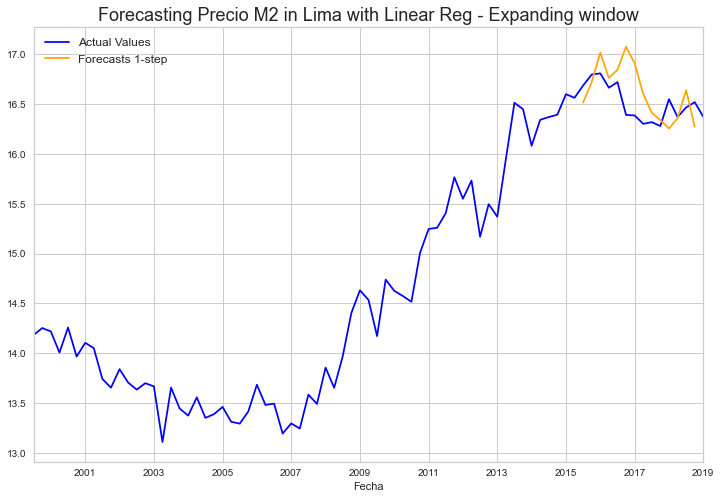

In [171]:
fig = plt.figure(figsize=(12,8))
original_series.reset_index().set_index('Fecha')['Precio_m2'].plot(color='blue')
df_time_series['preds'].plot(color='orange')
plt.title('Forecasting Precio M2 in Lima with Linear Reg - Expanding window', fontsize=18)
plt.legend(['Actual Values','Forecasts 1-step'],fontsize=12)

#### Basic testing

In [79]:
from pycaret.regression import *
setup(train_data, target='target')

 
Setup Succesfully Completed.


,Description,Value
0,session_id,7519
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(9184, 35)"
4,Missing Values,False
5,Numeric Features,30
6,Categorical Features,4
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


(      PCA_comp  CaptBurs Trimestral_LAG_1  CaptBurs Trimestral_LAG_2  \
 0     0.006924               48329.453333               45786.406667   
 1     0.006924               48329.453333               45786.406667   
 2     0.006924               48329.453333               45786.406667   
 3     0.074526               48329.453333               45786.406667   
 4     0.389204               48329.453333               45786.406667   
 ...        ...                        ...                        ...   
 9179  3.758640              356176.943333              357809.453333   
 9180  3.861474              356176.943333              357809.453333   
 9181  4.057049              356176.943333              357809.453333   
 9182  4.159883              356176.943333              357809.453333   
 9183  4.644997              356176.943333              357809.453333   
 
       CaptBurs Trimestral_LAG_3  CaptBurs Trimestral_LAG_4     INB_LAG_1  \
 0                  42421.316667             

In [80]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Extreme Gradient Boosting,0.0769,0.0111,0.1053,0.5601,0.0284,0.0286,0.8907
1,CatBoost Regressor,0.0768,0.0111,0.1053,0.5599,0.0284,0.0285,6.317
2,Gradient Boosting Regressor,0.077,0.0111,0.1054,0.5591,0.0284,0.0286,4.291
3,Light Gradient Boosting Machine,0.077,0.0111,0.1054,0.5586,0.0284,0.0286,0.4411
4,Extra Trees Regressor,0.078,0.0114,0.1065,0.5495,0.0287,0.029,4.307
5,Linear Regression,0.0784,0.0115,0.107,0.5457,0.0288,0.0291,0.1029
6,Bayesian Ridge,0.0783,0.0115,0.107,0.5457,0.0288,0.0291,0.0339
7,Ridge Regression,0.0783,0.0115,0.107,0.5457,0.0288,0.0291,0.0146
8,Random Sample Consensus,0.0782,0.0115,0.1073,0.5432,0.0289,0.029,0.6765
9,Random Forest,0.0785,0.0116,0.1078,0.5386,0.0291,0.0292,7.08


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=7519,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

In [85]:
lightgbm = create_model('lightgbm')

lgbm_params = {'num_leaves': np.arange(10,200,10),
                        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                        'learning_rate': [0.07]
                        }
tuned_lightgbm = tune_model(lightgbm, custom_grid = lgbm_params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0755,0.0099,0.0993,0.6074,0.0268,0.0281
1,0.0749,0.0105,0.1025,0.5876,0.0276,0.0278
2,0.0744,0.0104,0.1021,0.5991,0.0277,0.0277
3,0.0799,0.0115,0.1072,0.526,0.029,0.0299
4,0.0755,0.0106,0.1028,0.5887,0.0278,0.028
5,0.0783,0.0119,0.1092,0.5217,0.0294,0.0291
6,0.0747,0.0101,0.1005,0.5903,0.0271,0.0277
7,0.0795,0.0126,0.1124,0.535,0.0302,0.0294
8,0.0765,0.0107,0.1034,0.5758,0.0282,0.0285
9,0.073,0.011,0.1049,0.5376,0.0279,0.0269


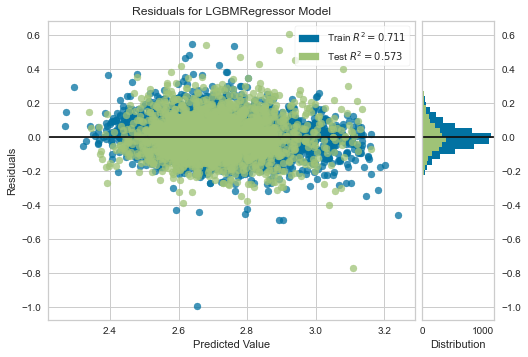

In [86]:
plot_model(tuned_lightgbm)

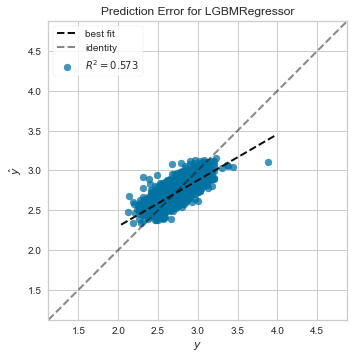

In [87]:
plot_model(tuned_lightgbm, plot = 'error')

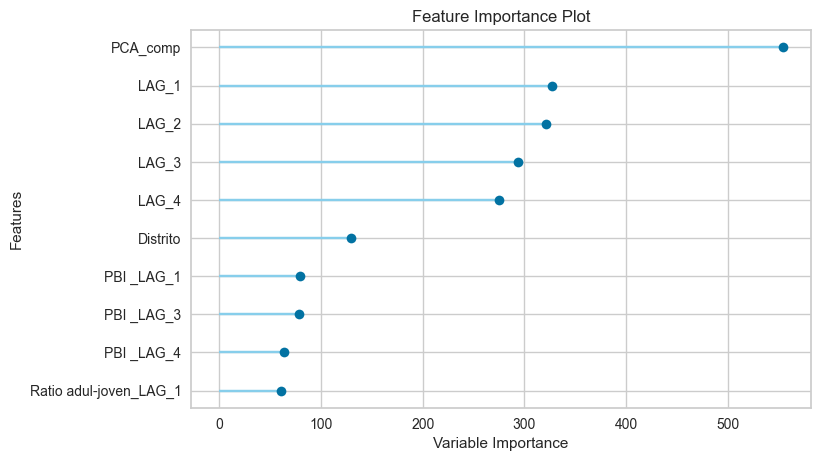

In [88]:
plot_model(tuned_lightgbm, plot='feature')

#### Trash

In [ ]:
def first_list_is_subset_of(l1,l2):
    if set(l1).issubset(l2) == True:
        return True
    else:
        return [elem for elem in l1 if elem not in l2]
    
#Check Time Series categories prevalence:
for period in data['Periodo'].unique():
    second_list = data[data['Periodo']==period]['Distrito'].value_counts().keys().tolist()
    if first_list_is_subset_of(prototyping_districts, second_list) != True:
        print(period, first_list_is_subset_of(prototyping_districts, second_list))

### Previous development

In [152]:
#Para pruebas y hacer el yt_
temp_df = to_train[(to_train['Fecha'] >= '2016-01-01')&(to_train['Fecha'] < '2017-01-01')]
#Reemplazo los nombres de las columnas as LAG_
dict_replace_dates = {elem:'LAG_'+str(n) for n,elem in enumerate(np.sort(temp_df['Fecha'].unique())[::-1],1)}
temp_df['Fecha'].replace(dict_replace_dates,inplace=True)

lagged_targets = pd.pivot_table(temp_df, values='Precio_m2',index=['PCA_comp','Distrito'], columns='Fecha').reset_index()

#Creo una dummy para luego reemplazar los lagged_targets
for lag_col in ['LAG_1','LAG_2','LAG_3','LAG_4']:
    lagged_targets[lag_col+'_isna'] = 0
    lagged_targets[lag_col+'_isna'].iloc[lagged_targets[lagged_targets[lag_col].isna()].index] = 1

lagged_targets

Fecha,PCA_comp,Distrito,LAG_1,LAG_2,LAG_3,LAG_4,LAG_1_isna,LAG_2_isna,LAG_3_isna,LAG_4_isna
0,0.067602,6,3.251074,NaN,NaN,NaN,0,1,1,1
1,0.074526,0,3.419073,NaN,NaN,NaN,0,1,1,1
2,0.074526,1,3.028229,NaN,NaN,NaN,0,1,1,1
3,0.074526,3,3.199534,NaN,NaN,NaN,0,1,1,1
4,0.074526,6,3.382712,NaN,NaN,NaN,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
692,6.295914,8,NaN,NaN,NaN,2.592167,1,1,1,0
693,6.388655,6,NaN,NaN,NaN,2.599599,1,1,1,0
694,6.473747,10,NaN,NaN,2.925678,NaN,1,1,0,1
695,6.881304,10,2.476709,NaN,NaN,NaN,0,1,1,1


In [163]:

#Creo los y_temporales pasados.
#yt_temp = temp_df.groupby(['PCA_comp','Distrito','Fecha'])['Precio_m2'].median().reset_index()
#yt_temp
#VERIFICAR SI SON DEL MES PASADO EN SI.<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

#el dataframe "pca_y_lags" tiene las columnas asociadas a los lags. Pero con nulos. Por eso, 
#reemplazaremos estos valos por su K vecinos más cercanos. 
#pca_y_lags = pd.pivot_table(yt_temp, values='Precio_m2', index=['PCA_comp','Distrito'], columns='Fecha').reset_index()
#pca_y_lags.sort_values('PCA_comp')
lagged_targets

Fecha,PCA_comp,Distrito,LAG_1,LAG_2,LAG_3,LAG_4,LAG_1_isna,LAG_2_isna,LAG_3_isna,LAG_4_isna
0,0.067602,6,3.251074,NaN,NaN,NaN,0,1,1,1
1,0.074526,0,3.419073,NaN,NaN,NaN,0,1,1,1
2,0.074526,1,3.028229,NaN,NaN,NaN,0,1,1,1
3,0.074526,3,3.199534,NaN,NaN,NaN,0,1,1,1
4,0.074526,6,3.382712,NaN,NaN,NaN,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
692,6.295914,8,NaN,NaN,NaN,2.592167,1,1,1,0
693,6.388655,6,NaN,NaN,NaN,2.599599,1,1,1,0
694,6.473747,10,NaN,NaN,2.925678,NaN,1,1,0,1
695,6.881304,10,2.476709,NaN,NaN,NaN,0,1,1,1


In [161]:
#Imputación con KNN.
#Recuerda que los identificadores son el índice PCA_comp resumiendo la característica de una casa.

#PD: Estoy perdiendo información al agrupar a las casas por tamaño y no agregar la variable distrito. Pero veremos 
#como hacerlo reacciona para poder hacer los experimentos luego. 

from sklearn.impute import KNNImputer

X = lagged_targets.iloc[:,:6]

imputer = KNNImputer(n_neighbors=5)
imputed_lagged_targets = imputer.fit_transform(X)

imputed_lagged_targets = pd.DataFrame(imputed_lagged_targets, columns = pca_y_lags.columns)

In [173]:
imputed_lagged_targets

NameError: name 'imputed_lagged_targets' is not defined